# Prática: Algoritmo de Machine learning para predição de hipotireoidismos

- O Hipotireoidismo é uma problema na glândula da tireoide que causa uma queda na produção de hormônios;
- O objeto desta prática é implementar um algoritmo de machine learning de árvore de decisão para predizer se uma pessoa possui hipotireoidismo ou não.

Esta prática foi oferta pelo [CIlab](https://github.com/cilab-ufersa/introduction_machine_learning/blob/main/parte_3_machine_learning/Aula06_Machine_Learning.ipynb).



In [1]:
# Realizando as importações das bibliotecas necessárias para a prática

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import StandardScaler

In [2]:
# carregando os dados e realizando uma visualização preliminar
dataset = pd.read_csv("hypothyroid.csv")
dataset.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P


In [3]:
# Observando detalhadamente as informações do dataframe
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on thyroxine               3772 non-null   object
 3   query on thyroxine         3772 non-null   object
 4   on antithyroid medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid surgery            3772 non-null   object
 8   I131 treatment             3772 non-null   object
 9   query hypothyroid          3772 non-null   object
 10  query hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

# Tratamento de dados
Das muitas características disponíveis para o problemas, selecionaremos apenas algumas colunas.
A escolha dos recursos pode ser feitos de diferentes formas, a principal trabalhada é o método de correlação de Pearson.

**OBS:** Como o foco da prática é no treinamento do modelo, não será abordado a a seleção das características

In [4]:
new_dataset = dataset.copy()[
    ["age", "sex", "tumor", "hypopituitary", "TSH", "TT4", "T4U", "binaryClass"]
]
new_dataset.head()

,age,sex,tumor,hypopituitary,TSH,TT4,T4U,binaryClass
0,41,F,f,f,1.3,125,1.14,P
1,23,F,f,f,4.1,102,?,P
2,46,M,f,f,0.98,109,0.91,P
3,70,F,f,f,0.16,175,?,P
4,70,F,f,f,0.72,61,0.87,P


Os dados do dataset estão descritos como object, ou seja, como textos, é preciso realizar a modificação dos valores para um tipo numérico para que o algoritmo funcione corretamente.

In [5]:
# Transformando os valores de variáveis categoricas para numerico
new_dataset["tumor"] = new_dataset["tumor"].astype("category").cat.codes.values
new_dataset["hypopituitary"] = (
    new_dataset["hypopituitary"].astype("category").cat.codes.values
)
new_dataset["sex"] = new_dataset["sex"].astype("category").cat.codes.values
new_dataset["binaryClass"] = (
    new_dataset["binaryClass"].astype("category").cat.codes.values
)  # df['classificação'] labels into numbers 0 is not sick and 1 is sick

In [6]:
new_dataset.head()

,age,sex,tumor,hypopituitary,TSH,TT4,T4U,binaryClass
0,41,1,0,0,1.3,125,1.14,1
1,23,1,0,0,4.1,102,?,1
2,46,2,0,0,0.98,109,0.91,1
3,70,1,0,0,0.16,175,?,1
4,70,1,0,0,0.72,61,0.87,1


Em algumas linhas existem valores que estão faltando e ao invés de serem substituidos por um NaN ou null, apresentam uma interrogação, são valores faltantes que é preciso realizar um tratamento adequado.

In [7]:
# verificando os dados faltantes marcados com ?
new_dataset[new_dataset == "?"].count()

age                1
sex                0
tumor              0
hypopituitary      0
TSH              369
TT4              231
T4U              387
binaryClass        0
dtype: int64

In [8]:
new_dataset.drop(new_dataset[new_dataset["age"] == "?"].index, inplace=True)
new_dataset.drop(new_dataset[new_dataset["sex"] == "?"].index, inplace=True)
new_dataset.drop(new_dataset[new_dataset["TSH"] == "?"].index, inplace=True)
new_dataset.drop(new_dataset[new_dataset["T4U"] == "?"].index, inplace=True)
new_dataset.drop(new_dataset[new_dataset["TT4"] == "?"].index, inplace=True)

Verificando se existe falta de algum dado.

In [9]:
new_dataset[new_dataset == "?"].count()

age              0
sex              0
tumor            0
hypopituitary    0
TSH              0
TT4              0
T4U              0
binaryClass      0
dtype: int64

Um ponto de atenção é verificar se o dataset está balanceado, ou seja, se a quantidade de pacientes que apresentam  e que não apresentam o problema de saúde está equilibrado.

In [10]:
new_dataset["binaryClass"].value_counts()

1    2957
0     266
Name: binaryClass, dtype: int64

## Balanceando o dataset

O nosso dataset está desbalanceado. Para resolve o problema, vamos usar a técnica SMOTE, que consiste em criar dados sintéticos para balancear o dataset.

Outra tarefa a ser executada é a de separar o nosso dataset em dados de entrada e dados de saída, ou seja, variáveis alvos e variáveis de recurso.

In [11]:
# Separado o dataset em outros dois, um com os recursos e outro com a variável alvo
out_dataset = new_dataset["binaryClass"]  # Dataset da variável alvo
dataset = new_dataset.drop(["binaryClass"], axis=1)  # Dataset de recursos

In [12]:
# Apresentando o dataset da variável alvo
out_dataset

0       1
2       1
4       1
5       1
7       1
       ..
3766    0
3768    1
3769    1
3770    1
3771    1
Name: binaryClass, Length: 3223, dtype: int8

In [13]:
# Apresentando o dataset dos recursos
dataset

,age,sex,tumor,hypopituitary,TSH,TT4,T4U
0,41,1,0,0,1.3,125,1.14
2,46,2,0,0,0.98,109,0.91
4,70,1,0,0,0.72,61,0.87
5,18,1,0,0,0.03,183,1.3
7,80,1,0,0,2.2,80,0.7
...,...,...,...,...,...,...,...
3766,19,1,0,0,8.8,108,1.11
3768,68,1,0,0,1,124,1.08
3769,74,1,0,0,5.1,112,1.07
3770,72,2,0,0,0.7,82,0.94


In [15]:
# Realizando o balanceamento pela Técnica SMOTE

# Importando a biblioteca
from imblearn.over_sampling import SMOTE

# Criando o objeto SMOTE
sm = SMOTE(random_state=42, k_neighbors=5)

# Balanceando
dataset_res, output_label = sm.fit_resample(dataset, out_dataset)

In [17]:
# Verificando os dados balanceados
output_label.value_counts()

1    2957
0    2957
Name: binaryClass, dtype: int64

## Preparando o conjunto de treino

Em muitos casos é interessante testar diferentes tamanhos de conjunto de treino e teste para obter uma resposta mais satisfatória, aqui vamos adotar o tamanho de 80% do dataset para treino e 20% para teste.

In [21]:
input_train, input_test, output_train, output_test = train_test_split(
    dataset_res, output_label, test_size=0.2
)

### Padronizado os dados

A padronização dos dados é um passo importante para que os dados possuam desvio padrão 1 e média 0, esse procedimento é importante para garantir que o algoritmo de machine learning convirga mais rápido, além de garantir que os dados estão em uma mesma escala.

In [22]:
scaler = StandardScaler()

input_train = scaler.fit_transform(input_train)  # padronizando os dados de treino
input_test = scaler.transform(input_test)  # padronizando os dados de teste

In [23]:
print("Treino:", input_train.shape, output_train.shape)
print("Teste:", input_test.shape, output_test.shape)

Treino: (4731, 7) (4731,)
Teste: (1183, 7) (1183,)


# Algoritmo de Machine Learning - Árvore de decisão

O algoritmo escolhido para esse projeto é o de árvore de decisão, um algoritmo de aprendizado supervisionado usado para classificação quanto para regressào.

In [24]:
model = DecisionTreeClassifier()

# Treinamento
model.fit(input_train, output_train)

# Classificação
output_model = model.predict(input_test)

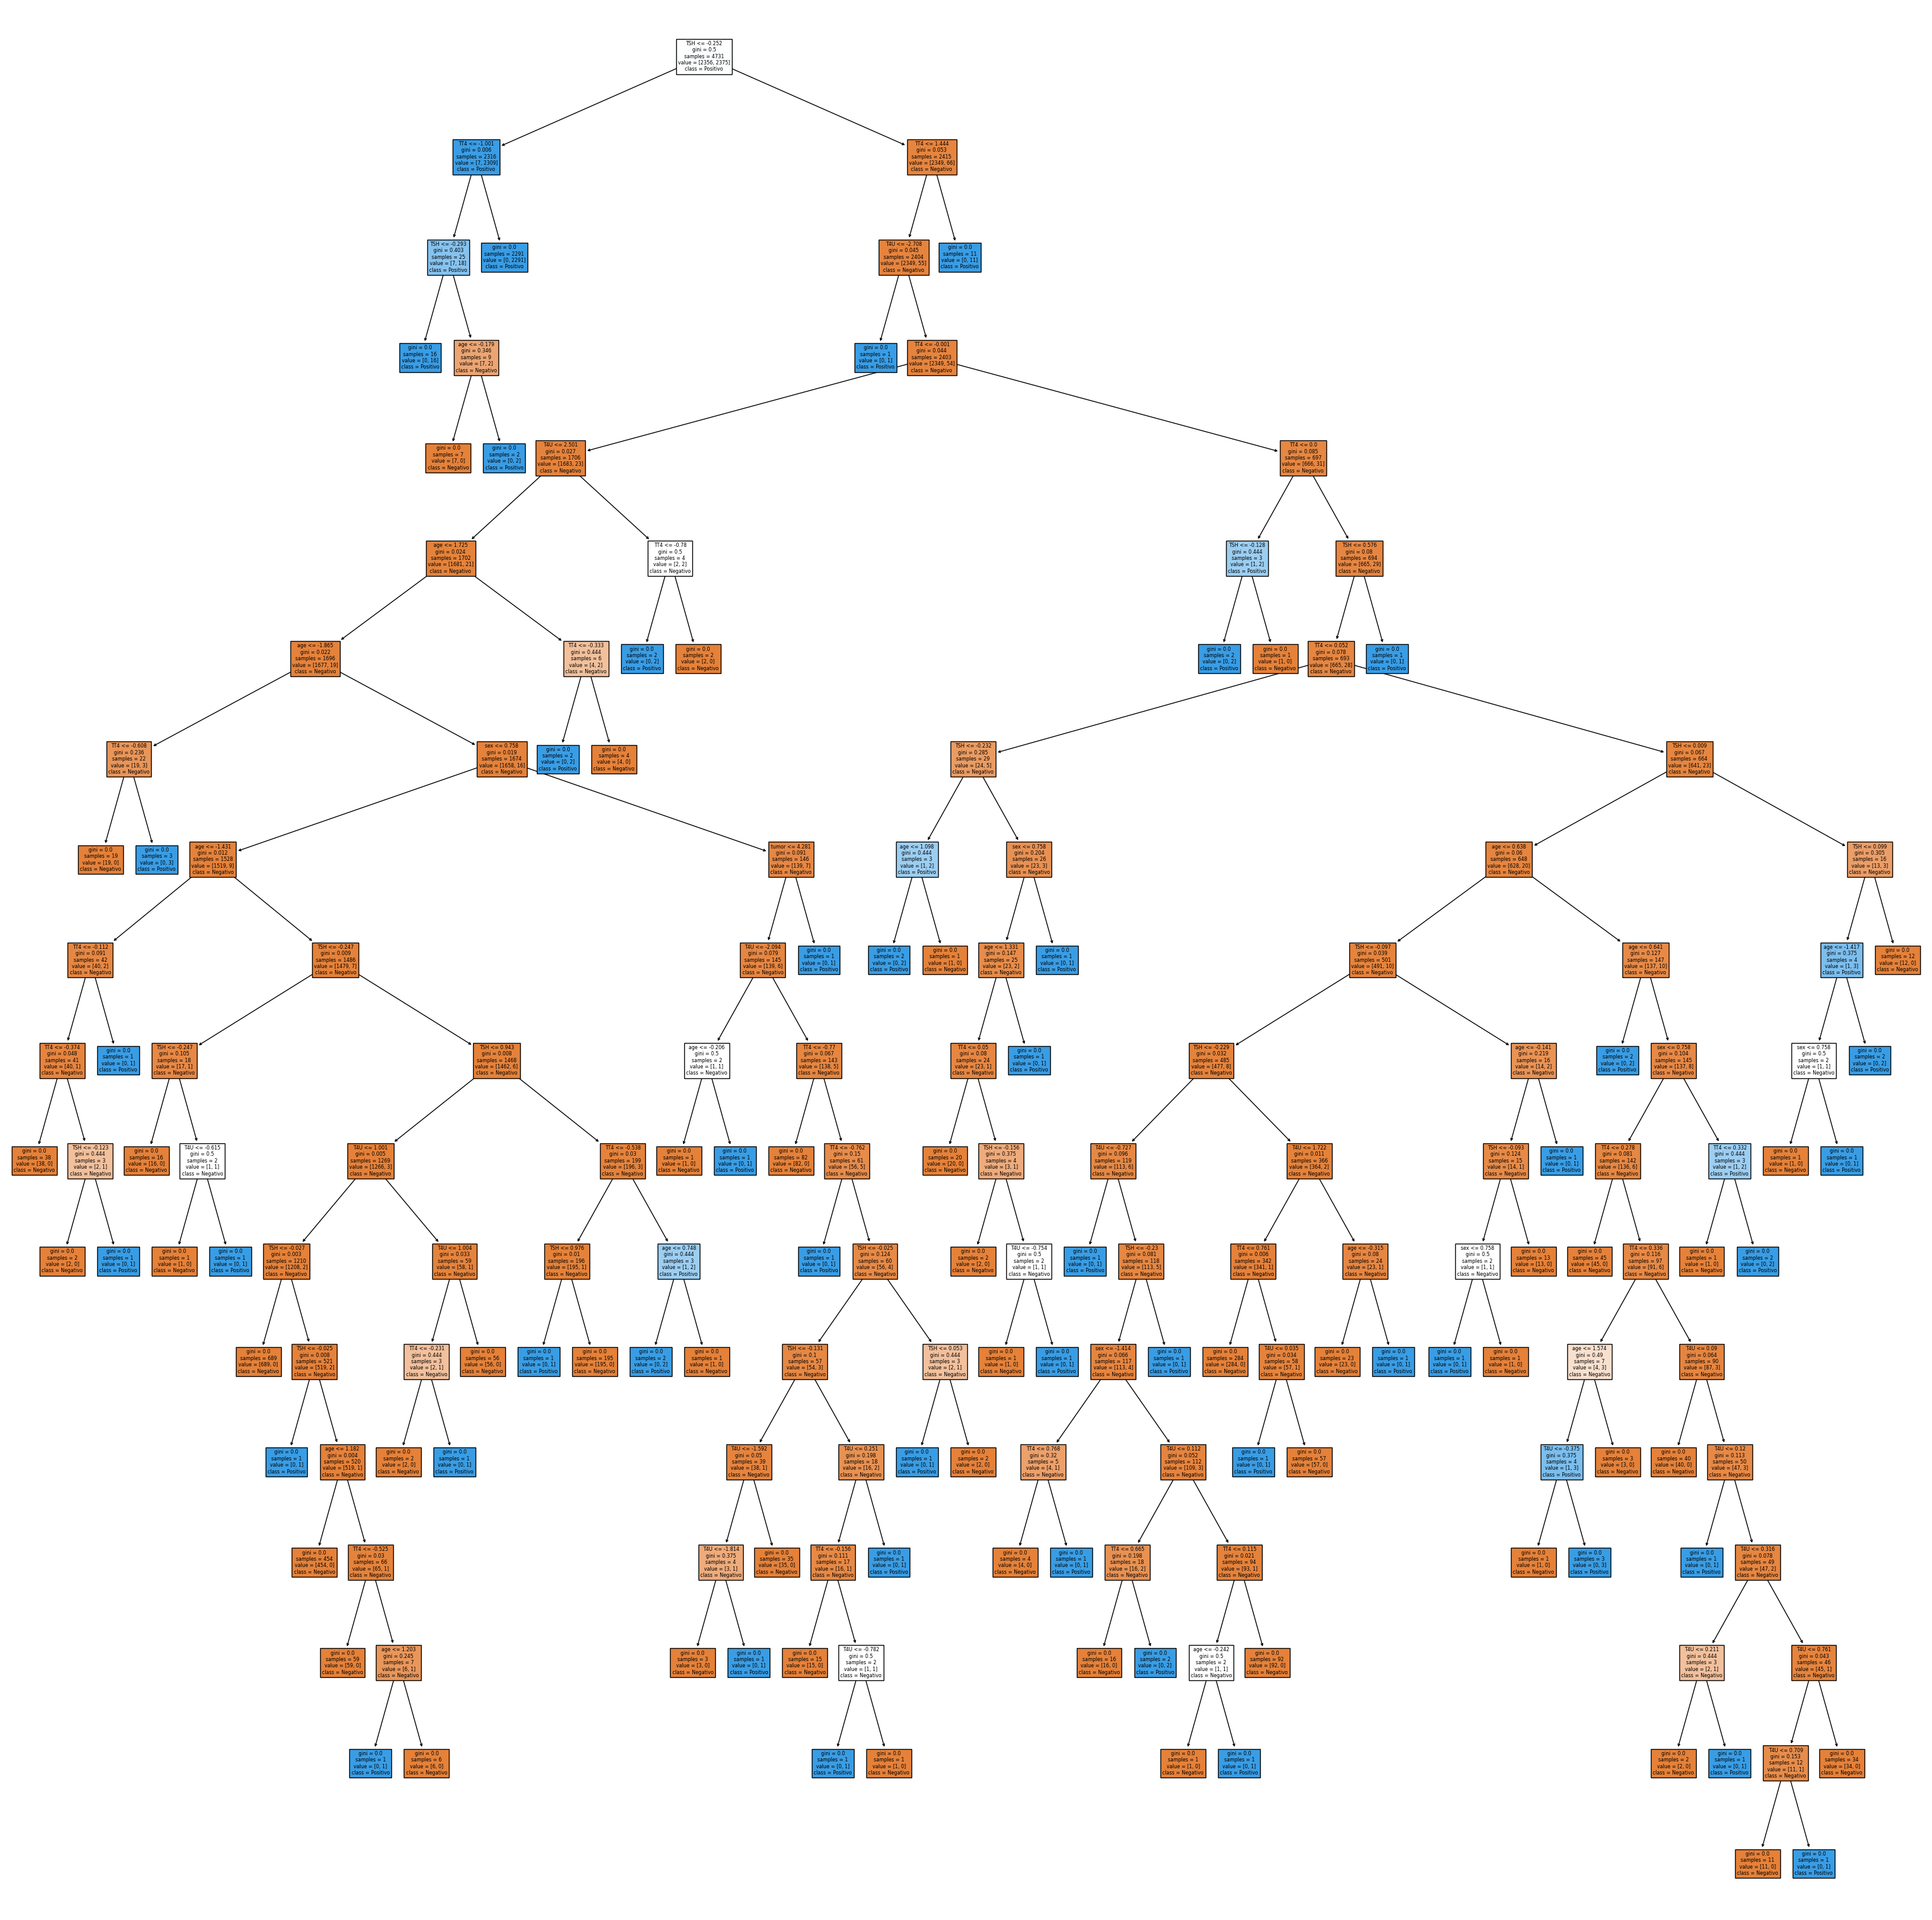

In [25]:
# Gráficamente
fig = plt.figure(figsize=(40, 40))

ax = tree.plot_tree(
    model,
    feature_names=new_dataset.columns,
    class_names=["Negativo", "Positivo"],
    filled=True,
)

In [27]:
txt_representarion = tree.export_text(model)
print(txt_representarion)

|--- feature_4 <= -0.25
|   |--- feature_5 <= -1.00
|   |   |--- feature_4 <= -0.29
|   |   |   |--- class: 1
|   |   |--- feature_4 >  -0.29
|   |   |   |--- feature_0 <= -0.18
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  -0.18
|   |   |   |   |--- class: 1
|   |--- feature_5 >  -1.00
|   |   |--- class: 1
|--- feature_4 >  -0.25
|   |--- feature_5 <= 1.44
|   |   |--- feature_6 <= -2.71
|   |   |   |--- class: 1
|   |   |--- feature_6 >  -2.71
|   |   |   |--- feature_5 <= -0.00
|   |   |   |   |--- feature_6 <= 2.50
|   |   |   |   |   |--- feature_0 <= 1.73
|   |   |   |   |   |   |--- feature_0 <= -1.86
|   |   |   |   |   |   |   |--- feature_5 <= -0.61
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_5 >  -0.61
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_0 >  -1.86
|   |   |   |   |   |   |   |--- feature_1 <= 0.76
|   |   |   |   |   |   |   |   |--- feature_0 <= -1.43
|   |   |   |   | 

In [28]:
# Salvando a árvore de decisão como figura
fig.savefig("decision_tree.png")

## Validando o modelo

In [29]:
# Por acurácia

from sklearn.metrics import accuracy_score

acuracia = accuracy_score(output_test, output_model)

print("Acurácia: %f" % acuracia)

Acurácia: 0.985630


In [30]:
# Criando uma matriz de confusão
from sklearn.metrics import confusion_matrix

confusion_matrix(output_test, output_model)

array([[591,  10],
       [  7, 575]], dtype=int64)

Visualmente não ficou tão interessante, melhorando a matriz de confusão

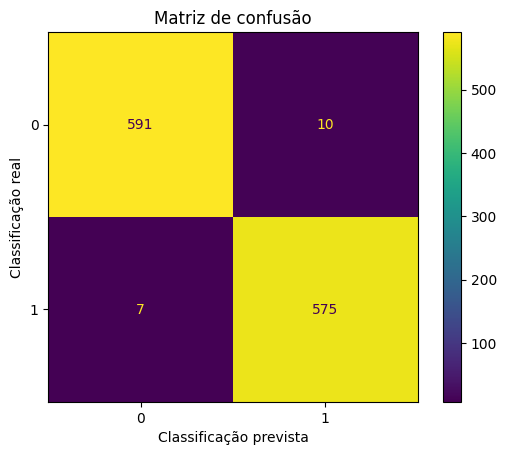

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(output_test, output_model)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

disp.ax_.set_title("Matriz de confusão")
disp.ax_.set_xlabel("Classificação prevista")
disp.ax_.set_ylabel("Classificação real")
plt.show()

# Testando o modelo

In [32]:
def predict(features):
    """
    Função que realiza predição para saber se um paciente possui ou não hipotireoidismo

    Args:
        features: dados do paciente
    """

    resposta = model.predict(pd.DataFrame(features))

    if resposta:
        print("Possui hipotireoidismo")
    else:
        print("Não possui hipotireoidismo")

In [33]:
"""
Dados de teste:
idade: 39
sexo: 0 (Feminino)
tumor: 0 (Não tem)
hypopituitary: 0 (Não tem)
TSH: 4.9877
TT4: 120
T4U: 1.98
"""
teste = scaler.transform([[39, 0, 0, 0, 4.9877, 120, 1.98]])

predict(teste)

Possui hipotireoidismo


C:\Users\AnD_B\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
